In [1]:
import numpy as np

b = np.load('dataverse_files/gns-water-drop-sample/train.npz/train.npz',allow_pickle=True)

# Torch and Torch Geometric

In [2]:
import os
import torch
print(f"PyTorch has version {torch.__version__} with cuda {torch.version.cuda}")

PyTorch has version 1.13.1+cu117 with cuda 11.7


In [3]:
import torch_geometric
print(f"PyTorch Geometric has version {torch_geometric.__version__}")

PyTorch Geometric has version 2.2.0


# Dataset

In [4]:
import json
import numpy as np
import torch_geometric as pyg

def generate_noise(position_seq, noise_std):
    """Generate noise for a trajectory"""
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]
    time_steps = velocity_seq.size(1)
    velocity_noise = torch.randn_like(velocity_seq) * (noise_std / time_steps ** 0.5)
    velocity_noise = velocity_noise.cumsum(dim=1)
    position_noise = velocity_noise.cumsum(dim=1)
    position_noise = torch.cat((torch.zeros_like(position_noise)[:, 0:1], position_noise), dim=1)
    return position_noise


def preprocess(particle_type, position_seq, target_position, metadata, noise_std):
    """Preprocess a trajectory and construct the graph"""
    # apply noise to the trajectory
    position_noise = generate_noise(position_seq, noise_std)
    position_seq = position_seq + position_noise

    # calculate the velocities of particles
    recent_position = position_seq[:, -1]
    velocity_seq = position_seq[:, 1:] - position_seq[:, :-1]

    # construct the graph based on the distances between particles
    n_particle = recent_position.size(0)
    edge_index = pyg.nn.radius_graph(recent_position, metadata["default_connectivity_radius"], loop=True, max_num_neighbors=n_particle)
    
    # node-level features: velocity, distance to the boundary
    normal_velocity_seq = (velocity_seq - torch.tensor(metadata["vel_mean"])) / torch.sqrt(torch.tensor(metadata["vel_std"]) ** 2 + noise_std ** 2)
    boundary = torch.tensor(metadata["bounds"])
    distance_to_lower_boundary = recent_position - boundary[:, 0]
    distance_to_upper_boundary = boundary[:, 1] - recent_position
    distance_to_boundary = torch.cat((distance_to_lower_boundary, distance_to_upper_boundary), dim=-1)
    distance_to_boundary = torch.clip(distance_to_boundary / metadata["default_connectivity_radius"], -1.0, 1.0)

    # edge-level features: displacement, distance
    dim = recent_position.size(-1)
    edge_displacement = (torch.gather(recent_position, dim=0, index=edge_index[0].unsqueeze(-1).expand(-1, dim)) -
                   torch.gather(recent_position, dim=0, index=edge_index[1].unsqueeze(-1).expand(-1, dim)))
    edge_displacement /= metadata["default_connectivity_radius"]
    edge_distance = torch.norm(edge_displacement, dim=-1, keepdim=True)

    # ground truth for training
    if target_position is not None:
        last_velocity = velocity_seq[:, -1]
        next_velocity = target_position + position_noise[:, -1] - recent_position
        acceleration = next_velocity - last_velocity
        acceleration = (acceleration - torch.tensor(metadata["acc_mean"])) / torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2)
    else:
        acceleration = None

    # return the graph with features
    graph = pyg.data.Data(
        x=particle_type,
        edge_index=edge_index,
        edge_attr=torch.cat((edge_displacement, edge_distance), dim=-1),
        y=acceleration,
        pos=torch.cat((velocity_seq.reshape(velocity_seq.size(0), -1), distance_to_boundary), dim=-1)
    )
    return graph

In [5]:
OUTPUT_DIR = 'dataverse_files\gns-water-drop-sample\metadata.json'

class OneStepDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7, noise_std=0.0, return_pos=False):
        super().__init__()

        # load dataset from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
        self.data = np.load(os.path.join(data_path, f"{split}.npz"),allow_pickle=True)
#         self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length
        self.noise_std = noise_std
        self.return_pos = return_pos

        #self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.particle_type = self.data['simulation_trajectory_0'][1]        
        #self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        self.position = []
        for i in '01':
            self.position.append(self.data['simulation_trajectory_'+i][0])
        
#         for traj in self.offset.values():
        self.dim = len(self.data['simulation_trajectory_0'][0][0][0])
#             break

        # cut particle trajectories according to time slices
        self.windows = []
        for traj in '0':
            string = '_'+traj
            #size = traj["position"]["shape"][1]
            size = len(self.data['simulation_trajectory'+string][0][0])
            length = len(self.data['simulation_trajectory'+string][0]) - window_length + 1
            for i in range(length):
                offset = i
                desc = {
                    "size": size,
                    "type": 0,
                    "pos": i,
                }
                self.windows.append(desc)

    def len(self):
        return len(self.windows)

    def get(self, idx):
        # load corresponding data for this time slice
        window = self.windows[idx]
        size = window["size"]
        particle_type = self.particle_type[window["type"]: window["type"] + size].copy()
        particle_type = torch.from_numpy(particle_type)
        position_seq = self.position[0][window["pos"]: window["pos"] + self.window_length ].copy()
#         position_seq.resize(self.window_length, size, self.dim)
#         print(position_seq.shape)
        position_seq = position_seq.transpose(1, 0, 2)
        target_position = position_seq[:, -1]
        position_seq = position_seq[:, :-1]
        target_position = torch.from_numpy(target_position)
        position_seq = torch.from_numpy(position_seq)
        
        # construct the graph
        with torch.no_grad():
            graph = preprocess(particle_type, position_seq, target_position, self.metadata, self.noise_std)
        if self.return_pos:
            return graph, position_seq[:, -1]
        return graph

In [6]:
class RolloutDataset(pyg.data.Dataset):
    def __init__(self, data_path, split, window_length=7):
        super().__init__()       
        
        self.data_name = ['simulation_trajectory_0']
        # load data from the disk
        with open(os.path.join(data_path, "metadata.json")) as f:
            self.metadata = json.load(f)
#         with open(os.path.join(data_path, f"{split}.npz")) as f:
#             self.data = np.load(f,allow_pickle=True)
        self.data = np.load(os.path.join(data_path, f"{split}.npz"),allow_pickle=True)
#         self.offset = {int(k): v for k, v in self.offset.items()}
        self.window_length = window_length


        #self.particle_type = np.memmap(os.path.join(data_path, f"{split}_particle_type.dat"), dtype=np.int64, mode="r")
        self.particle_type = self.data['simulation_trajectory_0'][1]        
        #self.position = np.memmap(os.path.join(data_path, f"{split}_position.dat"), dtype=np.float32, mode="r")
        self.position = self.data['simulation_trajectory_0'][0]

        self.dim = len(self.data['simulation_trajectory_0'][0][0][0])

    def len(self):
        return len(list(self.data_name))

    def get(self, idx):
        string = self.data_name[idx]
        
        traj = self.data[string]
        size  = len(self.data[string][0][0])
        time_step = len(self.data[string][0])
        particle_type = self.particle_type.copy()
        particle_type = torch.from_numpy(particle_type)
        position = self.position.copy()
        position = torch.from_numpy(position)
        data = {"particle_type": particle_type, "position": position}
        return data

The first item in the valid set is a graph: Data(x=[482], edge_index=[2, 3032], edge_attr=[3032, 3], y=[482, 2], pos=[482, 14])
This graph has 482 nodes and 3032 edges.
Each node is a particle and each edge is the interaction between two particles.
Each node has 1 categorial feature (Data.x), which represents the type of the node.
Each node has a 14-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.
Each edge has a 3-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.
The model is expected to predict a 2-dim vector for each node (Data.y), which represents the acceleration of the particle.


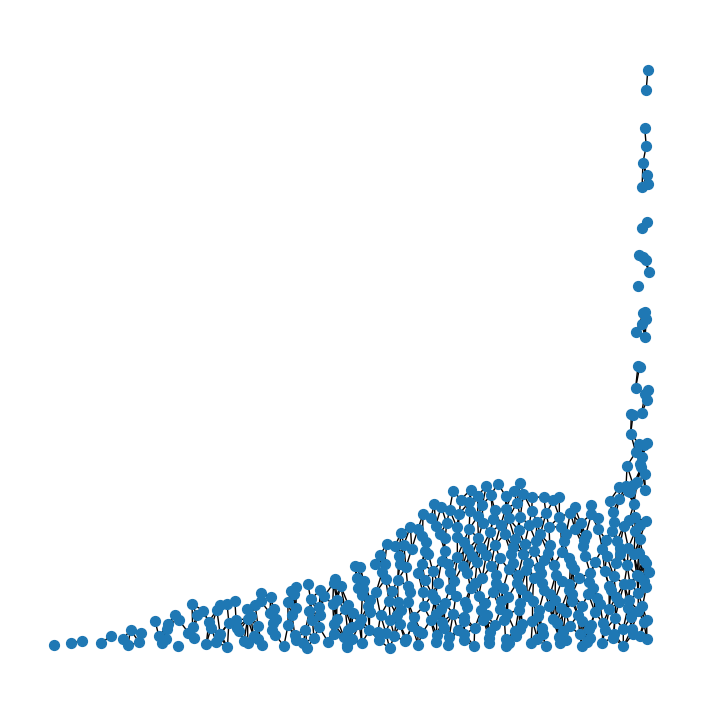

In [7]:
# %pip install matplotlib
# %pip install networkx
import matplotlib.pyplot as plt
import networkx as nx

dataset_sample = OneStepDataset(OUTPUT_DIR, "valid", return_pos=True)
graph, position = dataset_sample[100]

print(f"The first item in the valid set is a graph: {graph}")
print(f"This graph has {graph.num_nodes} nodes and {graph.num_edges} edges.")
print(f"Each node is a particle and each edge is the interaction between two particles.")
print(f"Each node has {graph.num_node_features} categorial feature (Data.x), which represents the type of the node.")
print(f"Each node has a {graph.pos.size(1)}-dim feature vector (Data.pos), which represents the positions and velocities of the particle (node) in several frames.")
print(f"Each edge has a {graph.num_edge_features}-dim feature vector (Data.edge_attr), which represents the relative distance and displacement between particles.")
print(f"The model is expected to predict a {graph.y.size(1)}-dim vector for each node (Data.y), which represents the acceleration of the particle.")

# remove directions of edges, because it is a symmetric directed graph.
nx_graph = pyg.utils.to_networkx(graph).to_undirected()
# remove self loops, because every node has a self loop.
nx_graph.remove_edges_from(nx.selfloop_edges(nx_graph))
plt.figure(figsize=(7, 7))
nx.draw(nx_graph, pos={i: tuple(v) for i, v in enumerate(position)}, node_size=50)
plt.show()

In [8]:
import math
import torch_scatter

class MLP(torch.nn.Module):
    """Multi-Layer perceptron"""
    def __init__(self, input_size, hidden_size, output_size, layers, layernorm=True):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(layers):
            self.layers.append(torch.nn.Linear(
                input_size if i == 0 else hidden_size,
                output_size if i == layers - 1 else hidden_size,
            ))
            if i != layers - 1:
                self.layers.append(torch.nn.ReLU())
        if layernorm:
            self.layers.append(torch.nn.LayerNorm(output_size))
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.data.normal_(0, 1 / math.sqrt(layer.in_features))
                layer.bias.data.fill_(0)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
class InteractionNetwork(pyg.nn.MessagePassing):
    """Interaction Network as proposed in this paper: 
    https://proceedings.neurips.cc/paper/2016/hash/3147da8ab4a0437c15ef51a5cc7f2dc4-Abstract.html"""
    def __init__(self, hidden_size, layers):
        super().__init__()
        self.lin_edge = MLP(hidden_size * 3, hidden_size, hidden_size, layers)
        self.lin_node = MLP(hidden_size * 2, hidden_size, hidden_size, layers)

    def forward(self, x, edge_index, edge_feature):
        edge_out, aggr = self.propagate(edge_index, x=(x, x), edge_feature=edge_feature)
        node_out = self.lin_node(torch.cat((x, aggr), dim=-1))
        edge_out = edge_feature + edge_out
        node_out = x + node_out
        return node_out, edge_out

    def message(self, x_i, x_j, edge_feature):
        x = torch.cat((x_i, x_j, edge_feature), dim=-1)
        x = self.lin_edge(x)
        return x

    def aggregate(self, inputs, index, dim_size=None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce="sum")
        return (inputs, out)

In [10]:
class LearnedSimulator(torch.nn.Module):
    """Graph Network-based Simulators(GNS)"""
    def __init__(
        self,
        hidden_size=128,
        n_mp_layers=10, # number of GNN layers
        num_particle_types=9,
        particle_type_dim=16, # embedding dimension of particle types
        dim=2, # dimension of the world, typical 2D or 3D
        window_size=5, # the model looks into W frames before the frame to be predicted
    ):
        super().__init__()
        self.window_size = window_size
        self.embed_type = torch.nn.Embedding(num_particle_types, particle_type_dim)
        self.node_in = MLP(particle_type_dim + dim * (window_size + 2), hidden_size, hidden_size, 3)
        self.edge_in = MLP(dim + 1, hidden_size, hidden_size, 3)
        self.node_out = MLP(hidden_size, hidden_size, dim, 3, layernorm=False)
        self.n_mp_layers = n_mp_layers
        self.layers = torch.nn.ModuleList([InteractionNetwork(
            hidden_size, 3
        ) for _ in range(n_mp_layers)])

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embed_type.weight)

    def forward(self, data):
        # pre-processing
        # node feature: combine categorial feature data.x and contiguous feature data.pos.
        node_feature = torch.cat((self.embed_type(data.x), data.pos), dim=-1)
        node_feature = self.node_in(node_feature)
        edge_feature = self.edge_in(data.edge_attr)
        # stack of GNN layers
        for i in range(self.n_mp_layers):
            node_feature, edge_feature = self.layers[i](node_feature, data.edge_index, edge_feature=edge_feature)
        # post-processing
        out = self.node_out(node_feature)
        return out

In [11]:
data_path = OUTPUT_DIR
model_path = os.path.join("temp", "models")
rollout_path = os.path.join("temp", "rollouts")

# !mkdir "$model_path"
# !mkdir "$rollout_path"



In [37]:
params = {
    "epoch": 50,
    "batch_size": 4,
    "lr": 1e-4,
    "noise": 3e-4,
    "save_interval": 100,
    "eval_interval": 50,
    "rollout_interval": 200,
}

In [38]:
def rollout(model, data, metadata, noise_std):
    device = next(model.parameters()).device
    model.eval()
    window_size = model.window_size + 1
    total_time = data["position"].size(0)
    traj = data["position"][:window_size]
    traj = traj.permute(1, 0, 2)
    particle_type = data["particle_type"]

    for time in range(total_time - window_size):
        with torch.no_grad():
            graph = preprocess(particle_type, traj[:, -window_size:], None, metadata, 0.0)
            graph = graph.to(device)
            acceleration = model(graph).cpu()
            acceleration = acceleration * torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise_std ** 2) + torch.tensor(metadata["acc_mean"])

            recent_position = traj[:, -1]
            recent_velocity = recent_position - traj[:, -2]
            new_velocity = recent_velocity + acceleration
            new_position = recent_position + new_velocity
            traj = torch.cat((traj, new_position.unsqueeze(1)), dim=1)

    return traj


def oneStepMSE(simulator, dataloader, metadata, noise):
    """Returns two values, loss and MSE"""
    total_loss = 0.0
    total_mse = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        scale = torch.sqrt(torch.tensor(metadata["acc_std"]) ** 2 + noise ** 2).cuda()
        for data in valid_loader:
            data = data.cuda()
            pred = simulator(data)
            mse = ((pred - data.y) * scale) ** 2
            mse = mse.sum(dim=-1).mean()
            loss = ((pred - data.y) ** 2).mean()
            total_mse += mse.item()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count, total_mse / batch_count


def rolloutMSE(simulator, dataset, noise):
    total_loss = 0.0
    batch_count = 0
    simulator.eval()
    with torch.no_grad():
        for rollout_data in dataset:
            rollout_out = rollout(simulator, rollout_data, dataset.metadata, noise)
            rollout_out = rollout_out.permute(1, 0, 2)
            loss = (rollout_out - rollout_data["position"]) ** 2
            loss = loss.sum(dim=-1).mean()
            total_loss += loss.item()
            batch_count += 1
    return total_loss / batch_count

In [39]:
from tqdm.notebook import tqdm

def train(params, simulator, train_loader, valid_loader, valid_rollout_dataset):
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(simulator.parameters(), lr=params["lr"])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1 ** (1 / 5e6))

    # recording loss curve
    train_loss_list = []
    eval_loss_list = []
    onestep_mse_list = []
    rollout_mse_list = []
    total_step = 0

    for i in range(params["epoch"]):
        simulator.train()
        progress_bar = tqdm(train_loader,desc=f"Epoch {i}")
        total_loss = 0
        batch_count = 0
        for data in progress_bar:
            optimizer.zero_grad()
            data = data.cuda()
            pred = simulator(data)
            loss = loss_fn(pred, data.y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({"loss": loss.item(), "avg_loss": total_loss / batch_count, "lr": optimizer.param_groups[0]["lr"]})
            total_step += 1
            train_loss_list.append((total_step, loss.item()))

            
#             print("DONE")
            # evaluation
            if total_step % params["eval_interval"] == 0:
                simulator.eval()
                eval_loss, onestep_mse = oneStepMSE(simulator, valid_loader, valid_dataset.metadata, params["noise"])
                eval_loss_list.append((total_step, eval_loss))
                onestep_mse_list.append((total_step, onestep_mse))
                tqdm.write(f"\nEval: Loss: {eval_loss}, One Step MSE: {onestep_mse}")
                simulator.train()

            # do rollout on valid set
            if total_step % params["rollout_interval"] == 0:
                simulator.eval()
                rollout_mse = rolloutMSE(simulator, valid_rollout_dataset, params["noise"])
                rollout_mse_list.append((total_step, rollout_mse))
                tqdm.write(f"\nEval: Rollout MSE: {rollout_mse}")
                simulator.train()

            # save model
            if total_step % params["save_interval"] == 0:
                torch.save(
                    {
                        "model": simulator.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "scheduler": scheduler.state_dict(),
                    },
                    os.path.join(model_path, f"checkpoint_{total_step}.pt")
                )
    return train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list

In [41]:

# load dataset
train_dataset = OneStepDataset(data_path, "train", noise_std=params["noise"])
valid_dataset = OneStepDataset(data_path, "valid", noise_std=params["noise"])
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True)
valid_loader = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True)
valid_rollout_dataset = RolloutDataset(data_path, "valid")

# build model
# simulator = LearnedSimulator()
# simulator = simulator.cuda()

# train the model
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)

Epoch 0:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.2272465398393003, One Step MSE: 4.358910291169462e-08

Eval: Loss: 0.20237408521544023, One Step MSE: 3.885885845675029e-08

Eval: Loss: 0.1963600149176207, One Step MSE: 3.7706741404386924e-08

Eval: Loss: 0.19866080755689536, One Step MSE: 3.81272910039938e-08

Eval: Rollout MSE: 0.12940770387649536


Epoch 1:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.24191910985961976, One Step MSE: 4.643255022776282e-08

Eval: Loss: 0.214072283851095, One Step MSE: 4.108706513080738e-08

Eval: Loss: 0.19991256132063617, One Step MSE: 3.839188958532571e-08

Eval: Loss: 0.20493494443984395, One Step MSE: 3.940703927386618e-08

Eval: Rollout MSE: 0.12093734741210938

Eval: Loss: 0.219287771477278, One Step MSE: 4.212053684151593e-08


Epoch 2:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.19134981651981192, One Step MSE: 3.675639387680635e-08

Eval: Loss: 0.26015733290149506, One Step MSE: 4.9982026792282986e-08

Eval: Loss: 0.19530329060363003, One Step MSE: 3.749631990176403e-08

Eval: Rollout MSE: 0.1815178245306015

Eval: Loss: 0.21576966099949726, One Step MSE: 4.14817912674568e-08

Eval: Loss: 0.186312694955303, One Step MSE: 3.577053101201293e-08


Epoch 3:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.21836052395134087, One Step MSE: 4.19704384125154e-08

Eval: Loss: 0.18416645380866575, One Step MSE: 3.53693777951657e-08

Eval: Rollout MSE: 0.13499970734119415

Eval: Loss: 0.21340081703112307, One Step MSE: 4.100290356955312e-08

Eval: Loss: 0.24087283769285822, One Step MSE: 4.620975363890974e-08

Eval: Loss: 0.18319412338805485, One Step MSE: 3.5190375679046306e-08


Epoch 4:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.22285206185047884, One Step MSE: 4.276675007704864e-08

Eval: Rollout MSE: 0.27346232533454895

Eval: Loss: 0.18238932166592664, One Step MSE: 3.503105205826172e-08

Eval: Loss: 0.18301683248405953, One Step MSE: 3.514441602707636e-08

Eval: Loss: 0.25721503854037286, One Step MSE: 4.958466723872199e-08

Eval: Loss: 0.19596323140534053, One Step MSE: 3.762509821775351e-08

Eval: Rollout MSE: 0.17332270741462708


Epoch 5:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.2692334484383763, One Step MSE: 5.175689556543113e-08

Eval: Loss: 0.2070363014338007, One Step MSE: 3.976995757258132e-08

Eval: Loss: 0.18133632099652386, One Step MSE: 3.480896813806544e-08

Eval: Loss: 0.22766331203251958, One Step MSE: 4.374320253097117e-08

Eval: Rollout MSE: 0.17772088944911957

Eval: Loss: 0.17816621989729892, One Step MSE: 3.417414176364315e-08


Epoch 6:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.22683198229376092, One Step MSE: 4.358524152569563e-08

Eval: Loss: 0.18327517774569463, One Step MSE: 3.5187893730441614e-08

Eval: Loss: 0.22732213791833825, One Step MSE: 4.371578242284155e-08

Eval: Rollout MSE: 0.10838160663843155

Eval: Loss: 0.1975689955863608, One Step MSE: 3.79517723379044e-08

Eval: Loss: 0.17511940720569658, One Step MSE: 3.3612382253694024e-08


Epoch 7:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16944570567114764, One Step MSE: 3.2529973831096104e-08

Eval: Loss: 0.1683466271703023, One Step MSE: 3.2313947180712726e-08

Eval: Rollout MSE: 0.1401621699333191

Eval: Loss: 0.1866700787800383, One Step MSE: 3.5901165570961836e-08

Eval: Loss: 0.22707822188794852, One Step MSE: 4.3623601866034916e-08

Eval: Loss: 0.17417184805056177, One Step MSE: 3.342741435370594e-08


Epoch 8:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.17939827636063818, One Step MSE: 3.444487697299472e-08

Eval: Rollout MSE: 0.13752998411655426

Eval: Loss: 0.3752075713801097, One Step MSE: 7.249258052032778e-08

Eval: Loss: 0.19608426722417394, One Step MSE: 3.7649807113102745e-08

Eval: Loss: 0.18394637224544963, One Step MSE: 3.530653593315262e-08

Eval: Loss: 0.19387912968674817, One Step MSE: 3.72282903478355e-08

Eval: Rollout MSE: 0.26017624139785767


Epoch 9:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.18031234991358944, One Step MSE: 3.4626886411305474e-08

Eval: Loss: 0.20993202380147805, One Step MSE: 4.034423513338337e-08

Eval: Loss: 0.17669353628134632, One Step MSE: 3.39197095293258e-08

Eval: Loss: 0.2002282836530582, One Step MSE: 3.846932717223523e-08

Eval: Rollout MSE: 0.15847112238407135

Eval: Loss: 0.16685481327604576, One Step MSE: 3.2028576745710415e-08


Epoch 10:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1724867272568515, One Step MSE: 3.3137643675927505e-08

Eval: Loss: 0.16739683930414267, One Step MSE: 3.210773554392372e-08

Eval: Loss: 0.16727832621000857, One Step MSE: 3.2095841465163e-08

Eval: Rollout MSE: 0.10116244852542877

Eval: Loss: 0.18222339801400542, One Step MSE: 3.500297514040724e-08

Eval: Loss: 0.2704460561036106, One Step MSE: 5.191938075895962e-08


Epoch 11:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.17909115699520073, One Step MSE: 3.4374869622787774e-08

Eval: Loss: 0.17696462329252657, One Step MSE: 3.400423709856258e-08

Eval: Rollout MSE: 0.17422522604465485

Eval: Loss: 0.18858303734097615, One Step MSE: 3.62023494413089e-08

Eval: Loss: 0.19716894695438056, One Step MSE: 3.7877206007105927e-08

Eval: Loss: 0.15521153607162605, One Step MSE: 2.9786034554498003e-08


Epoch 12:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1687406903230043, One Step MSE: 3.2379940149945673e-08

Eval: Rollout MSE: 0.17634733021259308

Eval: Loss: 0.1657568389871513, One Step MSE: 3.183845641213322e-08

Eval: Loss: 0.17831623153274798, One Step MSE: 3.4285045663718265e-08

Eval: Loss: 0.16317156319278311, One Step MSE: 3.133834135700815e-08

Eval: Loss: 0.1781562529354689, One Step MSE: 3.4193455499439005e-08

Eval: Rollout MSE: 0.17131473124027252


Epoch 13:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16084130614038453, One Step MSE: 3.0880053798280394e-08

Eval: Loss: 0.15723678610291347, One Step MSE: 3.019464196032928e-08

Eval: Loss: 0.15162106968432545, One Step MSE: 2.9106270767962117e-08

Eval: Loss: 0.20013651015409026, One Step MSE: 3.852731144735869e-08

Eval: Rollout MSE: 0.1048651859164238

Eval: Loss: 0.20040492845108232, One Step MSE: 3.8483251263031264e-08


Epoch 14:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.186419355791496, One Step MSE: 3.573854359795672e-08

Eval: Loss: 0.1570197972188513, One Step MSE: 3.0144648794096e-08

Eval: Loss: 0.17771033143781753, One Step MSE: 3.4100347149314964e-08

Eval: Rollout MSE: 0.10962632298469543

Eval: Loss: 0.15633967306360183, One Step MSE: 3.0011827432868345e-08

Eval: Loss: 0.15887241239049826, One Step MSE: 3.048136139210487e-08


Epoch 15:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1694320754772688, One Step MSE: 3.2505265231806336e-08

Eval: Loss: 0.15717166560481352, One Step MSE: 3.017598337917882e-08

Eval: Rollout MSE: 0.1657429188489914

Eval: Loss: 0.1554842640956243, One Step MSE: 2.985288676322889e-08

Eval: Loss: 0.16290966579952393, One Step MSE: 3.128895702459714e-08

Eval: Loss: 0.16243667520552754, One Step MSE: 3.11422080733645e-08


Epoch 16:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16843565909498667, One Step MSE: 3.234253975569598e-08

Eval: Rollout MSE: 0.1117105782032013

Eval: Loss: 0.18108761223803563, One Step MSE: 3.4711776071978955e-08

Eval: Loss: 0.1713666403329516, One Step MSE: 3.2855801014268613e-08

Eval: Loss: 0.16694277360377063, One Step MSE: 3.2047085363820225e-08

Eval: Loss: 0.15217745133552207, One Step MSE: 2.9214213862852983e-08

Eval: Rollout MSE: 0.10330014675855637


Epoch 17:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.17507556167592006, One Step MSE: 3.365823806369549e-08

Eval: Loss: 0.1463741462632834, One Step MSE: 2.8085298816624817e-08

Eval: Loss: 0.1543025492903698, One Step MSE: 2.963344411800466e-08

Eval: Loss: 0.17035423943316602, One Step MSE: 3.274215475809672e-08

Eval: Rollout MSE: 0.12365056574344635

Eval: Loss: 0.16437183275639292, One Step MSE: 3.15421502892558e-08


Epoch 18:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.15792170567924238, One Step MSE: 3.03058791948354e-08

Eval: Loss: 0.1559932630165035, One Step MSE: 2.994640504157994e-08

Eval: Loss: 0.15903383693900933, One Step MSE: 3.051731668082891e-08

Eval: Rollout MSE: 0.17071646451950073

Eval: Loss: 0.16499652830233058, One Step MSE: 3.170105672300581e-08

Eval: Loss: 0.1654096778975912, One Step MSE: 3.1721102517570466e-08


Epoch 19:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1492753247300305, One Step MSE: 2.8656757541677485e-08

Eval: Loss: 0.2078353320977774, One Step MSE: 4.001609800145917e-08

Eval: Rollout MSE: 0.103309765458107

Eval: Loss: 0.1585339106709124, One Step MSE: 3.0436772752318666e-08

Eval: Loss: 0.21197408644190754, One Step MSE: 4.07168524831209e-08

Eval: Loss: 0.16534282350875287, One Step MSE: 3.17720764253961e-08


Epoch 20:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14665036582683463, One Step MSE: 2.8153849472182884e-08

Eval: Rollout MSE: 0.13156327605247498

Eval: Loss: 0.15105508417489538, One Step MSE: 2.9007925510990595e-08

Eval: Loss: 0.13860853985849633, One Step MSE: 2.6613722178301504e-08

Eval: Loss: 0.13894216818024355, One Step MSE: 2.6673707733423446e-08

Eval: Loss: 0.15743610397519836, One Step MSE: 3.0197820051764995e-08

Eval: Rollout MSE: 0.1039014384150505


Epoch 21:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16613119448643612, One Step MSE: 3.1900160235799116e-08

Eval: Loss: 0.1580663926031695, One Step MSE: 3.036843300881593e-08

Eval: Loss: 0.15198367717395345, One Step MSE: 2.9210286038254612e-08

Eval: Loss: 0.16512854765337634, One Step MSE: 3.173523798412944e-08

Eval: Rollout MSE: 0.12294822186231613

Eval: Loss: 0.14924643781170788, One Step MSE: 2.8647282083330038e-08


Epoch 22:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14695336612831636, One Step MSE: 2.82243955186528e-08

Eval: Loss: 0.14358975409144858, One Step MSE: 2.7577039415079816e-08

Eval: Loss: 0.15297714213889288, One Step MSE: 2.94034700202297e-08

Eval: Rollout MSE: 0.10688769817352295

Eval: Loss: 0.15420591876090292, One Step MSE: 2.9615853644527015e-08

Eval: Loss: 0.15140949102889104, One Step MSE: 2.9085902550363186e-08


Epoch 23:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14823822380907564, One Step MSE: 2.847804983708583e-08

Eval: Loss: 0.16786554518593363, One Step MSE: 3.2194198949747465e-08

Eval: Rollout MSE: 0.2853570282459259

Eval: Loss: 0.161812903741038, One Step MSE: 3.107750894466826e-08

Eval: Loss: 0.217982504621567, One Step MSE: 4.192056385555446e-08

Eval: Loss: 0.16955305531202072, One Step MSE: 3.2553350540856364e-08


Epoch 24:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.20946464011348395, One Step MSE: 4.0362068550411164e-08

Eval: Rollout MSE: 0.2900193929672241

Eval: Loss: 0.14605263994640136, One Step MSE: 2.8047921243923435e-08

Eval: Loss: 0.1359667084422935, One Step MSE: 2.610206597941065e-08

Eval: Loss: 0.2100139323427495, One Step MSE: 4.02634380561886e-08

Eval: Loss: 0.1408206582308773, One Step MSE: 2.7019554786338302e-08

Eval: Rollout MSE: 0.1791929453611374


Epoch 25:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1701714729807942, One Step MSE: 3.272819699142735e-08

Eval: Loss: 0.19260586355345316, One Step MSE: 3.707248924266345e-08

Eval: Loss: 0.19986415427013574, One Step MSE: 3.8314642275482935e-08

Eval: Loss: 0.15000703918885994, One Step MSE: 2.8785966898858102e-08

Eval: Rollout MSE: 0.08303762972354889

Eval: Loss: 0.14291958169764782, One Step MSE: 2.744156417316711e-08


Epoch 26:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.15049573859895568, One Step MSE: 2.8915238528403585e-08

Eval: Loss: 0.1670850746064301, One Step MSE: 3.2120452832101183e-08

Eval: Loss: 0.15212932369675503, One Step MSE: 2.9193040670247273e-08

Eval: Rollout MSE: 0.07918980717658997

Eval: Loss: 0.1385384227886018, One Step MSE: 2.6609296381669157e-08

Eval: Loss: 0.13945120730134378, One Step MSE: 2.6779210010574507e-08


Epoch 27:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.21685438274020652, One Step MSE: 4.1722256728476224e-08

Eval: Loss: 0.2157188062686997, One Step MSE: 4.139532123418123e-08

Eval: Rollout MSE: 0.18539337813854218

Eval: Loss: 0.1477038981505187, One Step MSE: 2.8374280289022153e-08

Eval: Loss: 0.14604057616976848, One Step MSE: 2.8063494293243855e-08

Eval: Loss: 0.17292676010285038, One Step MSE: 3.321125650973912e-08


Epoch 28:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1406900764379396, One Step MSE: 2.6999895420725847e-08

Eval: Rollout MSE: 0.13998565077781677

Eval: Loss: 0.14672765387109962, One Step MSE: 2.820502356971715e-08

Eval: Loss: 0.14454331204115625, One Step MSE: 2.774323268930488e-08

Eval: Loss: 0.14251165382234926, One Step MSE: 2.735685506240154e-08

Eval: Loss: 0.19900749928979988, One Step MSE: 3.819603776863354e-08

Eval: Rollout MSE: 0.34235653281211853


Epoch 29:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.18008735698150344, One Step MSE: 3.468977227560364e-08

Eval: Loss: 0.1358921797908693, One Step MSE: 2.609320727001765e-08

Eval: Loss: 0.1504077632803036, One Step MSE: 2.8871109026922624e-08

Eval: Loss: 0.1477603302542943, One Step MSE: 2.8374161380123364e-08

Eval: Rollout MSE: 0.08986662328243256

Eval: Loss: 0.14339149530872283, One Step MSE: 2.7565709614974133e-08


Epoch 30:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14161955921286082, One Step MSE: 2.7174475749500215e-08

Eval: Loss: 0.16805033125432142, One Step MSE: 3.221108661013849e-08

Eval: Loss: 0.17272388764533653, One Step MSE: 3.32024769802038e-08

Eval: Rollout MSE: 0.15597641468048096

Eval: Loss: 0.15842608188888635, One Step MSE: 3.039976246457921e-08

Eval: Loss: 0.20897289853258785, One Step MSE: 4.0087827197892634e-08


Epoch 31:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1426270458114195, One Step MSE: 2.7387763243369312e-08

Eval: Loss: 0.17674942619829292, One Step MSE: 3.3999639851392395e-08

Eval: Rollout MSE: 0.13850165903568268

Eval: Loss: 0.13111623897250876, One Step MSE: 2.516767146316505e-08

Eval: Loss: 0.13491690455071897, One Step MSE: 2.5906204760154964e-08

Eval: Loss: 0.13006833114896912, One Step MSE: 2.4984860887919724e-08


Epoch 32:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14948255909853672, One Step MSE: 2.866378628963152e-08

Eval: Rollout MSE: 0.15662908554077148

Eval: Loss: 0.13509351018083143, One Step MSE: 2.594993642190957e-08

Eval: Loss: 0.13578105290012665, One Step MSE: 2.6044230657872043e-08

Eval: Loss: 0.13500227538277826, One Step MSE: 2.5905473546760804e-08

Eval: Loss: 0.13960598513902908, One Step MSE: 2.6799194570765945e-08

Eval: Rollout MSE: 0.07768315076828003


Epoch 33:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.15682966953300567, One Step MSE: 3.013937679885047e-08

Eval: Loss: 0.1521232387866361, One Step MSE: 2.9232058473069054e-08

Eval: Loss: 0.15566304134556566, One Step MSE: 2.987326970532789e-08

Eval: Loss: 0.16408733098980893, One Step MSE: 3.152128475951449e-08

Eval: Rollout MSE: 0.44365963339805603

Eval: Loss: 0.12638529301826734, One Step MSE: 2.4252556703648526e-08


Epoch 34:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.19332975161123467, One Step MSE: 3.713893835393709e-08

Eval: Loss: 0.14841564496358237, One Step MSE: 2.8527090251831412e-08

Eval: Loss: 0.133470970493962, One Step MSE: 2.5621017371947692e-08

Eval: Rollout MSE: 0.06826910376548767

Eval: Loss: 0.1366734934529387, One Step MSE: 2.6201877907878605e-08

Eval: Loss: 0.13859721614294743, One Step MSE: 2.6603637672112893e-08


Epoch 35:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1374174579379549, One Step MSE: 2.637536268819067e-08

Eval: Loss: 0.14779526563772716, One Step MSE: 2.8352267136454083e-08

Eval: Rollout MSE: 0.09199633449316025

Eval: Loss: 0.1274797335626131, One Step MSE: 2.4490122683031462e-08

Eval: Loss: 0.17125362507909178, One Step MSE: 3.2837280860540285e-08

Eval: Loss: 0.16028870675099421, One Step MSE: 3.0789236984149e-08


Epoch 36:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1334149845124009, One Step MSE: 2.5618209019557248e-08

Eval: Rollout MSE: 0.11558336019515991

Eval: Loss: 0.2234123762113502, One Step MSE: 4.29423642526375e-08

Eval: Loss: 0.1447865708345869, One Step MSE: 2.7787639562842446e-08

Eval: Loss: 0.1709933363529573, One Step MSE: 3.2888206389394416e-08

Eval: Loss: 0.1467678791517953, One Step MSE: 2.817884871270082e-08

Eval: Rollout MSE: 0.18903611600399017


Epoch 37:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.13577847013691344, One Step MSE: 2.608018667426033e-08

Eval: Loss: 0.13896599040931487, One Step MSE: 2.670213022402282e-08

Eval: Loss: 0.12203379569343295, One Step MSE: 2.3422248333619917e-08

Eval: Loss: 0.1359029841351222, One Step MSE: 2.607320348022838e-08

Eval: Rollout MSE: 0.15023325383663177

Eval: Loss: 0.15005770933077517, One Step MSE: 2.879137287349971e-08


Epoch 38:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.3444183458794791, One Step MSE: 6.657222598974556e-08

Eval: Loss: 0.14027094948722654, One Step MSE: 2.6926750681910283e-08

Eval: Loss: 0.1358510466165332, One Step MSE: 2.6086608714313133e-08

Eval: Rollout MSE: 0.09626585245132446

Eval: Loss: 0.14754149781532555, One Step MSE: 2.832296813503184e-08

Eval: Loss: 0.164889819830297, One Step MSE: 3.1587500643695876e-08


Epoch 39:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1315144956052064, One Step MSE: 2.5254419168123672e-08

Eval: Loss: 0.131320194128048, One Step MSE: 2.5212655891663184e-08

Eval: Rollout MSE: 0.07928255945444107

Eval: Loss: 0.14626135156456246, One Step MSE: 2.8092122777030932e-08

Eval: Loss: 0.1603749979392113, One Step MSE: 3.081942919343501e-08

Eval: Loss: 0.1316906996968999, One Step MSE: 2.528777173737983e-08


Epoch 40:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.14791711769908308, One Step MSE: 2.8397562109937753e-08

Eval: Rollout MSE: 0.18603508174419403

Eval: Loss: 0.1361468909794547, One Step MSE: 2.6127237594314658e-08

Eval: Loss: 0.12666680671304584, One Step MSE: 2.4313470298209604e-08

Eval: Loss: 0.13770669739109925, One Step MSE: 2.6446664624433493e-08

Eval: Loss: 0.14837824164265132, One Step MSE: 2.8514359309248362e-08

Eval: Rollout MSE: 0.10848002880811691


Epoch 41:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16213487091672468, One Step MSE: 3.118631803135324e-08

Eval: Loss: 0.15645827251265806, One Step MSE: 3.001392331278597e-08

Eval: Loss: 0.12143585311780014, One Step MSE: 2.3320276604923963e-08

Eval: Loss: 0.14503637653397747, One Step MSE: 2.7855122232005073e-08

Eval: Rollout MSE: 0.09851578623056412

Eval: Loss: 0.12409190534348469, One Step MSE: 2.3820736708447624e-08


Epoch 42:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.12162543061267898, One Step MSE: 2.336943247573014e-08

Eval: Loss: 0.1536077360910584, One Step MSE: 2.949985794955008e-08

Eval: Loss: 0.13618105157731047, One Step MSE: 2.614110849071401e-08

Eval: Rollout MSE: 0.18522563576698303

Eval: Loss: 0.13165506373447586, One Step MSE: 2.5287936860092303e-08

Eval: Loss: 0.14110265176997605, One Step MSE: 2.711493115891224e-08


Epoch 43:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.13070147505486346, One Step MSE: 2.5074834974111035e-08

Eval: Loss: 0.13343729647287883, One Step MSE: 2.559828252269238e-08

Eval: Rollout MSE: 0.08076541125774384

Eval: Loss: 0.11606992279968588, One Step MSE: 2.2287451117138864e-08

Eval: Loss: 0.12953708356762506, One Step MSE: 2.4881275749238058e-08

Eval: Loss: 0.14216024195214352, One Step MSE: 2.7331458470833725e-08


Epoch 44:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.15471502797431255, One Step MSE: 2.9691133935229625e-08

Eval: Rollout MSE: 0.20061829686164856

Eval: Loss: 0.15480696658293405, One Step MSE: 2.9776669130399114e-08

Eval: Loss: 0.1561474230694005, One Step MSE: 3.001813855406115e-08

Eval: Loss: 0.14043646023036485, One Step MSE: 2.6996013581654335e-08

Eval: Loss: 0.1254107860406958, One Step MSE: 2.4086324449448482e-08

Eval: Rollout MSE: 0.1383768767118454


Epoch 45:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.13080967745807276, One Step MSE: 2.5100132963606335e-08

Eval: Loss: 0.11702833737594535, One Step MSE: 2.2470441414752366e-08

Eval: Loss: 0.1250200890543231, One Step MSE: 2.3995660159450524e-08

Eval: Loss: 0.13561073158041062, One Step MSE: 2.6054353608988396e-08

Eval: Rollout MSE: 0.2088291496038437

Eval: Loss: 0.12456635022199297, One Step MSE: 2.391581069015598e-08


Epoch 46:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.12402142837164871, One Step MSE: 2.3820213293133856e-08

Eval: Loss: 0.11783937686478278, One Step MSE: 2.2623679943267525e-08

Eval: Loss: 0.32054694972363823, One Step MSE: 6.141116931891326e-08

Eval: Rollout MSE: 0.31050819158554077

Eval: Loss: 0.1394391741798106, One Step MSE: 2.6793124962763665e-08

Eval: Loss: 0.13188146811771584, One Step MSE: 2.5315675303495282e-08


Epoch 47:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.1375054723347526, One Step MSE: 2.645213718748771e-08

Eval: Loss: 0.12799722684854006, One Step MSE: 2.458620052750694e-08

Eval: Rollout MSE: 0.14737313985824585

Eval: Loss: 0.12353674090471134, One Step MSE: 2.3705730972143516e-08

Eval: Loss: 0.1231356155291858, One Step MSE: 2.365723123690267e-08

Eval: Loss: 0.1351315541768888, One Step MSE: 2.591568927863569e-08


Epoch 48:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.2192900434854519, One Step MSE: 4.226374926959928e-08

Eval: Rollout MSE: 0.07909712195396423

Eval: Loss: 0.1936522303934557, One Step MSE: 3.729975396108657e-08

Eval: Loss: 0.11747391583270816, One Step MSE: 2.2550430905909825e-08

Eval: Loss: 0.12867186858831162, One Step MSE: 2.4694104139478417e-08

Eval: Loss: 0.11609323852392564, One Step MSE: 2.2288846573847553e-08

Eval: Rollout MSE: 0.08407241851091385


Epoch 49:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.46914942412970057, One Step MSE: 9.034846171341296e-08

Eval: Loss: 0.16920127851297578, One Step MSE: 3.253445877541743e-08

Eval: Loss: 0.14829865774237008, One Step MSE: 2.8485789819770054e-08

Eval: Loss: 0.16658788003835334, One Step MSE: 3.2069433142066646e-08

Eval: Rollout MSE: 0.09505140036344528

Eval: Loss: 0.13999346930937595, One Step MSE: 2.6904838614033923e-08


In [376]:
train_loss_list, eval_loss_list, onestep_mse_list, rollout_mse_list = train(params, simulator, train_loader, valid_loader, valid_rollout_dataset)

Epoch 0:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.17888656052121196, One Step MSE: 3.43231346138291e-08

Eval: Loss: 0.1609968220792621, One Step MSE: 3.088848154138887e-08

Eval: Loss: 0.18349789621600185, One Step MSE: 3.5224752079032614e-08

Eval: Loss: 0.18918956020270963, One Step MSE: 3.631611749206771e-08

Eval: Rollout MSE: 0.17922937870025635


Epoch 1:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.17702624246657614, One Step MSE: 3.401679935145155e-08

Eval: Loss: 0.18513530037968035, One Step MSE: 3.5544201884329004e-08

Eval: Loss: 0.16011924347484927, One Step MSE: 3.0730192987326484e-08

Eval: Loss: 0.15844077269834686, One Step MSE: 3.0366948873377564e-08

Eval: Rollout MSE: 0.07693172991275787

Eval: Loss: 0.2218765448853673, One Step MSE: 4.2532691335896016e-08


Epoch 2:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.24236902833942428, One Step MSE: 4.642063165097243e-08

Eval: Loss: 0.16603908753658395, One Step MSE: 3.1829586470315145e-08

Eval: Loss: 0.16383997826691132, One Step MSE: 3.1430060474806407e-08

Eval: Rollout MSE: 0.13529250025749207

Eval: Loss: 0.18856053808367396, One Step MSE: 3.6206588991563717e-08

Eval: Loss: 0.19494907127087374, One Step MSE: 3.747169987419451e-08


Epoch 3:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.16033770036266512, One Step MSE: 3.076413133343582e-08

Eval: Loss: 0.17819100373001942, One Step MSE: 3.4280090733900635e-08

Eval: Rollout MSE: 0.041860684752464294

Eval: Loss: 0.17729720521164707, One Step MSE: 3.4000802123812603e-08

Eval: Loss: 0.19833466733794614, One Step MSE: 3.80956354690401e-08

Eval: Loss: 0.1750551763787327, One Step MSE: 3.3608815907011526e-08


Epoch 4:   0%|          | 0/249 [00:00<?, ?it/s]


Eval: Loss: 0.21528163384720983, One Step MSE: 4.1218976590697364e-08

Eval: Rollout MSE: 0.23920732736587524

Eval: Loss: 0.19666467394575057, One Step MSE: 3.7730877378284695e-08

Eval: Loss: 0.15696357804010191, One Step MSE: 3.0100238310773054e-08

Eval: Loss: 0.15282325168330985, One Step MSE: 2.932333964399978e-08

Eval: Loss: 0.18763750187125072, One Step MSE: 3.600579674840112e-08

Eval: Rollout MSE: 0.1566690057516098


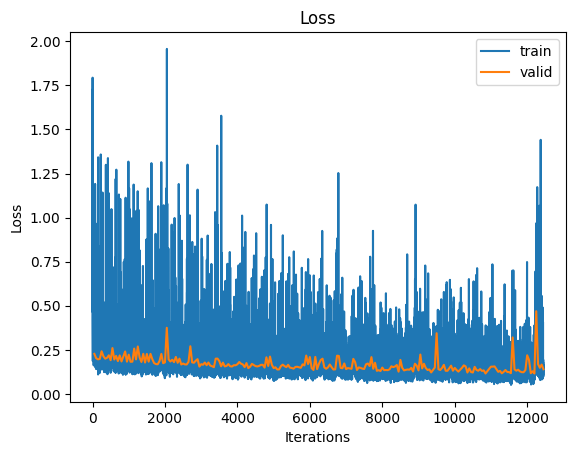

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

# visualize the loss curve
plt.figure()
plt.plot(*zip(*train_loss_list), label="train")
plt.plot(*zip(*eval_loss_list), label="valid")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [50]:
# torch.save(simulator,"temp/models/best_performer.pt")

In [49]:
simulator.keys()

dict_keys(['model', 'optimizer', 'scheduler'])

In [51]:
simulator = torch.load("temp/models/best_performer.pt")


In [47]:
type(simulator['model'])

collections.OrderedDict

In [63]:
simulator = LearnedSimulator()
simulator = simulator.cuda()


checkpoint = torch.load("temp/models/checkpoint_12400.pt")
simulator.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [64]:
rollout_dataset = RolloutDataset(data_path, "valid")
simulator.eval()
rollout_data = rollout_dataset[0]
rollout_out = rollout(simulator, rollout_data, rollout_dataset.metadata, params["noise"])
rollout_out = rollout_out.permute(1, 0, 2)

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

TYPE_TO_COLOR = {
    3: "black",
    0: "green",
    7: "magenta",
    6: "gold",
    5: "blue",
}


def visualize_prepare(ax, particle_type, position, metadata):
    bounds = metadata["bounds"]
    ax.set_xlim(bounds[0][0], bounds[0][1])
    ax.set_ylim(bounds[1][0], bounds[1][1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    points = {type_: ax.plot([], [], "o", ms=2, color=color)[0] for type_, color in TYPE_TO_COLOR.items()}
    return ax, position, points


def visualize_pair(particle_type, position_pred, position_gt, metadata):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plot_info = [
        visualize_prepare(axes[0], particle_type, position_gt, metadata),
        visualize_prepare(axes[1], particle_type, position_pred, metadata),
    ]
    axes[0].set_title("Ground truth")
    axes[1].set_title("Prediction")

    plt.close()

    def update(step_i):
        outputs = []
        for _, position, points in plot_info:
            for type_, line in points.items():
                mask = particle_type == type_
                line.set_data(position[step_i, mask, 0], position[step_i, mask, 1])
            outputs.append(line)
        return outputs

    return animation.FuncAnimation(fig, update, frames=np.arange(0, position_gt.size(0)), interval=10, blit=True)

anim = visualize_pair(rollout_data["particle_type"], rollout_out, rollout_data["position"], rollout_dataset.metadata)
HTML(anim.to_html5_video())

In [20]:
l = pyg.loader.DataLoader(valid_dataset, batch_size=params["batch_size"], shuffle=False, pin_memory=True)

In [309]:
k = train_dataset
m = torch_geometric.loader.DataLoader(train_dataset, batch_size=4, shuffle=True)


In [308]:
len(train_dataset)/4

497.0

In [310]:
for n,i in enumerate(m):
    m0 = i
    print(n,m0.size)
    

0 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 20810], edge_attr=[20810, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
1 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 25960], edge_attr=[25960, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
2 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 22908], edge_attr=[22908, 3], y=[2712, 2], pos=[2712, 14], batch=[2712], ptr=[5])>
3 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 18732], edge_attr=[18732, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
4 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 25964], edge_attr=[25964, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
5 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 23594], edge_attr=[23594, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
6 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 27216], edge_attr=[27216, 

66 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 23940], edge_attr=[23940, 3], y=[2712, 2], pos=[2712, 14], batch=[2712], ptr=[5])>
67 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 20740], edge_attr=[20740, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
68 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 19086], edge_attr=[19086, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
69 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 22334], edge_attr=[22334, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
70 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 22462], edge_attr=[22462, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
71 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 24588], edge_attr=[24588, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
72 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 26356], edge_attr=[

130 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 23704], edge_attr=[23704, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
131 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 24088], edge_attr=[24088, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
132 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 24634], edge_attr=[24634, 3], y=[2712, 2], pos=[2712, 14], batch=[2712], ptr=[5])>
133 <bound method BaseData.size of DataBatch(x=[1420], edge_index=[2, 23780], edge_attr=[23780, 3], y=[2712, 2], pos=[2712, 14], batch=[1420], ptr=[5])>
134 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 24434], edge_attr=[24434, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
135 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 20780], edge_attr=[20780, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
136 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 21926], edge

196 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 18110], edge_attr=[18110, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
197 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 19480], edge_attr=[19480, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
198 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 18250], edge_attr=[18250, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
199 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 21694], edge_attr=[21694, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
200 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 21972], edge_attr=[21972, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
201 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 26964], edge_attr=[26964, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
202 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 24692], edge

262 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 22046], edge_attr=[22046, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
263 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 24352], edge_attr=[24352, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
264 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 23920], edge_attr=[23920, 3], y=[2712, 2], pos=[2712, 14], batch=[2712], ptr=[5])>
265 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 19808], edge_attr=[19808, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
266 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 24862], edge_attr=[24862, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
267 <bound method BaseData.size of DataBatch(x=[1420], edge_index=[2, 26230], edge_attr=[26230, 3], y=[2712, 2], pos=[2712, 14], batch=[1420], ptr=[5])>
268 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 23426], edge

326 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 25464], edge_attr=[25464, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
327 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 22138], edge_attr=[22138, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
328 <bound method BaseData.size of DataBatch(x=[1420], edge_index=[2, 23132], edge_attr=[23132, 3], y=[2712, 2], pos=[2712, 14], batch=[1420], ptr=[5])>
329 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 22896], edge_attr=[22896, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
330 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 23016], edge_attr=[23016, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
331 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 23848], edge_attr=[23848, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
332 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 22524], edge

389 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 23944], edge_attr=[23944, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
390 <bound method BaseData.size of DataBatch(x=[2712], edge_index=[2, 23124], edge_attr=[23124, 3], y=[2712, 2], pos=[2712, 14], batch=[2712], ptr=[5])>
391 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 24532], edge_attr=[24532, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
392 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 23874], edge_attr=[23874, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
393 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 22102], edge_attr=[22102, 3], y=[2712, 2], pos=[2712, 14], batch=[1743], ptr=[5])>
394 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 23256], edge_attr=[23256, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
395 <bound method BaseData.size of DataBatch(x=[1743], edge_index=[2, 22574], edge

455 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 23280], edge_attr=[23280, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
456 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 21316], edge_attr=[21316, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
457 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 20626], edge_attr=[20626, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
458 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 19470], edge_attr=[19470, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
459 <bound method BaseData.size of DataBatch(x=[2066], edge_index=[2, 22066], edge_attr=[22066, 3], y=[2712, 2], pos=[2712, 14], batch=[2066], ptr=[5])>
460 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 21246], edge_attr=[21246, 3], y=[2712, 2], pos=[2712, 14], batch=[2389], ptr=[5])>
461 <bound method BaseData.size of DataBatch(x=[2389], edge_index=[2, 24344], edge

In [306]:
for n,i in enumerate(l):
    l0 = i
    print(n,l0.size)
    

0 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12320], edge_attr=[12320, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
1 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12398], edge_attr=[12398, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
2 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12352], edge_attr=[12352, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
3 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12338], edge_attr=[12338, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
4 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12298], edge_attr=[12298, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
5 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12332], edge_attr=[12332, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
6 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 12336], edge_attr=[12336, 

76 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13370], edge_attr=[13370, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
77 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13444], edge_attr=[13444, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
78 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13506], edge_attr=[13506, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
79 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13546], edge_attr=[13546, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
80 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13786], edge_attr=[13786, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
81 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13944], edge_attr=[13944, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
82 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 13998], edge_attr=[

150 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16952], edge_attr=[16952, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
151 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16766], edge_attr=[16766, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
152 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16908], edge_attr=[16908, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
153 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16932], edge_attr=[16932, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
154 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16916], edge_attr=[16916, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
155 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 16924], edge_attr=[16924, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
156 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 17032], edge

219 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18178], edge_attr=[18178, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
220 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18078], edge_attr=[18078, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
221 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18112], edge_attr=[18112, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
222 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18006], edge_attr=[18006, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
223 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18238], edge_attr=[18238, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
224 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18000], edge_attr=[18000, 3], y=[1928, 2], pos=[1928, 14], batch=[1928], ptr=[5])>
225 <bound method BaseData.size of DataBatch(x=[1928], edge_index=[2, 18008], edge

290 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11826], edge_attr=[11826, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
291 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11704], edge_attr=[11704, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
292 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11826], edge_attr=[11826, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
293 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11784], edge_attr=[11784, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
294 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11842], edge_attr=[11842, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
295 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11858], edge_attr=[11858, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
296 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 11790], edge

366 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15458], edge_attr=[15458, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
367 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15708], edge_attr=[15708, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
368 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15662], edge_attr=[15662, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
369 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15656], edge_attr=[15656, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
370 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15666], edge_attr=[15666, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
371 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15792], edge_attr=[15792, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
372 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 15736], edge

437 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17510], edge_attr=[17510, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
438 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17528], edge_attr=[17528, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
439 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17550], edge_attr=[17550, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
440 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17534], edge_attr=[17534, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
441 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17598], edge_attr=[17598, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
442 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17666], edge_attr=[17666, 3], y=[1928, 2], pos=[1928, 14], batch=[1448], ptr=[5])>
443 <bound method BaseData.size of DataBatch(x=[1448], edge_index=[2, 17728], edge

In [241]:
k[600]

Data(x=[678], edge_index=[2, 6232], edge_attr=[6232, 3], y=[678, 2], pos=[678, 14])

In [204]:
k[0].x

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [169]:
m0.x.unsqueeze(1)

tensor([[5],
        [5],
        [5],
        ...,
        [5],
        [5],
        [5]])

In [164]:
k[35]

Data(x=[643], edge_index=[2, 4334], edge_attr=[4334, 3], y=[678, 2], pos=[678, 14])

In [160]:
m0.y.shape

torch.Size([21696, 2])

In [135]:
len(train_dataset)

1988

In [134]:
type(train_dataset)

__main__.OneStepDataset

In [96]:
train_loader = pyg.loader.DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, pin_memory=True, num_workers=2)